In [30]:
# Reload modules automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple Soil Profile

`simplesoilprofile` (`ssp`) is a lightweight library for creating and working with soil profiles in hydrological modelling workflows. It helps to initially conceptualize profiles, discretize and parametrize them. `ssp` also integrates with `dovwms`, an API wrapper for Databank Ondergrond Vlaanderen.

This notebook demonstrates a complete workflow:

- Constructing a conceptual soil profile from individual `SoilLayer` objects.
- Configuring numerical discretization for each layer (even / logarithmic splits).
- Visualizing the profile and its sublayer boundaries with `plot_profile`.
- Converting the profile to model-ready tables used by SWAP / pySWAP (for example `SOILHYDRFUNC` and `SOILPROFILE`).

Run the cells below to recreate the example profile, inspect discretization patterns, and generate the export tables that downstream models expect.

In [16]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

from simplesoilprofile import SoilLayer, SoilProfile, plot_profile

## Layer
The basic building block of a profile is a Layer. It's understood here as a portion of a profile having specific physical and hydraulic properties. Layers also hold information about numerical discratization. We will create a simple profile with 3 layers.

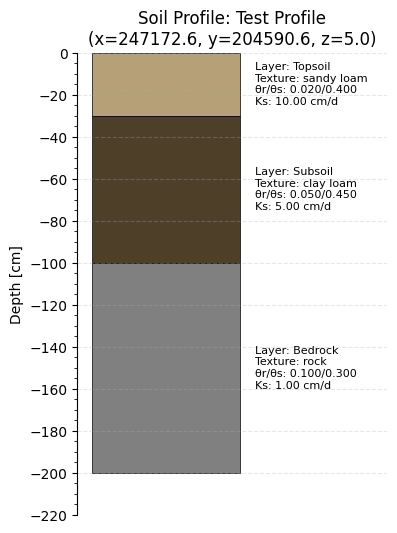

In [17]:
# Create soil layers
topsoil = SoilLayer(
    name="Topsoil",
    theta_res=0.02,
    theta_sat=0.4,
    alpha=0.02,
    n=1.5,
    k_sat=10.0,
    texture_class="sandy loam",
)

subsoil = SoilLayer(
    name="Subsoil",
    theta_res=0.05,
    theta_sat=0.45,
    alpha=0.01,
    n=1.3,
    k_sat=5.0,
    texture_class="clay loam",
)

bedrock = SoilLayer(
    name="Bedrock",
    theta_res=0.1,
    theta_sat=0.3,
    alpha=0.005,
    n=1.2,
    k_sat=1.0,
    texture_class="rock",
)

# Create soil profile
profile = SoilProfile(
    name="Test Profile",
    layers=[topsoil, subsoil, bedrock],
    layer_bottoms=[30, 100, 200],
    location=Point(247172.56, 204590.58),
    elevation=5.0,
)

# Create plot
fig, ax = plt.subplots(figsize=(4, 6))
plot_profile(profile, ax=ax, show_layer_properties=True)
plt.show()

### Layer discretization
In most models, the conceptual model of the soil column is further divided into compartments between which fluxes are calculated. simplesoilprofile provides several ways to do the discratization automatically. Below we are going to define three LayerDiscretization objects. They are simple objects merely holding the information about the type and parameters of the discretization to be applied to the layer. There are three currently available types:

- Even split - user provides the number of compartments needed and the the H of each compartment is adjusted to fit the required number of sublayers.
- logarythmic split (fine top) - user provide the required number of layer and log density, which when applied creates compartments H logarythmically increasing downwards.
- logarythmic split (fine bottom) - the same as above, but reversed.
- logarythmic split symetrical - the split is done both ways looking from the center. The middle compartments are the biggest and the H of compartments decreases towards the boundaries of the layers.

After creating the discretization configuration and adding it them to the layers we can plot the new profile which now includes the discretization.

In [18]:
from simplesoilprofile.models.discretization import DiscretizationType, LayerDiscretization

even = LayerDiscretization(
        type=DiscretizationType.EVEN,
        num_sublayers=5,
        num_compartments=10,
    )

log_both = LayerDiscretization(
        type=DiscretizationType.LOG_BOTH,
        num_sublayers=11,
        num_compartments=5,
        log_density=3
    )
log_top = LayerDiscretization(
        type=DiscretizationType.LOG_TOP,
        num_sublayers=8,
        num_compartments=2,
        log_density=2.0
    )


In [19]:
# Add the discretizations to the layers
topsoil.discretization, subsoil.discretization, bedrock.discretization = even, log_top, log_both

In [20]:
bedrock.discretization.compartment_heights

[np.float64(0.021537743572508268),
 np.float64(0.03924432748145716),
 np.float64(0.07150782691264498),
 np.float64(0.13029575579260091),
 np.float64(0.23741434624078867),
 np.float64(0.23741434624078872),
 np.float64(0.1302957557926009),
 np.float64(0.0715078269126449),
 np.float64(0.03924432748145723),
 np.float64(0.02153774357250826)]

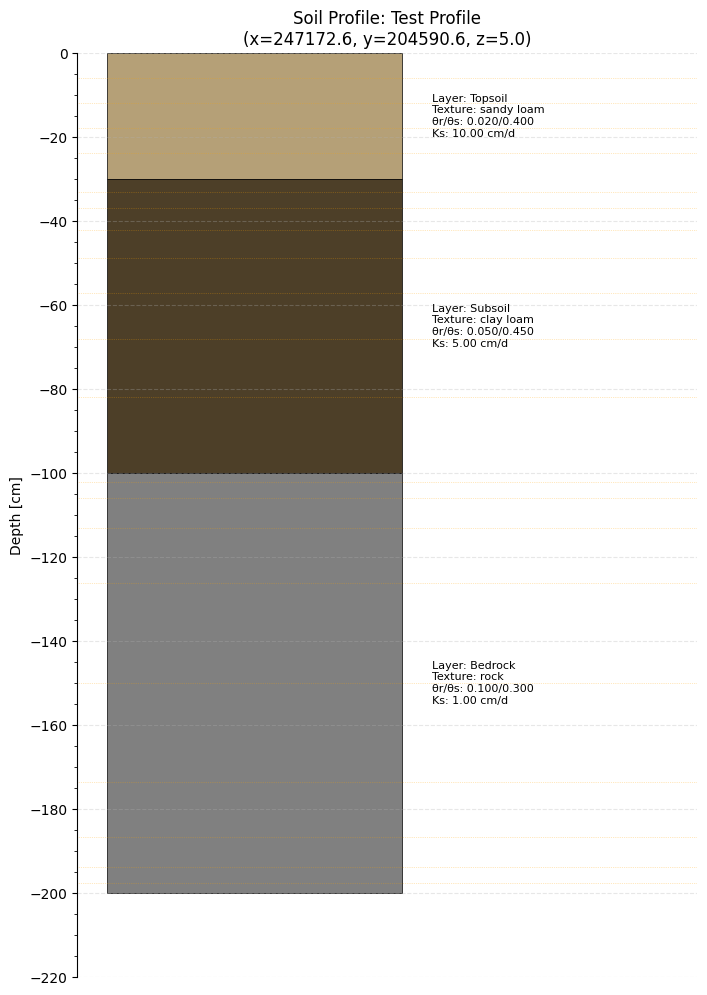

In [21]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_profile(profile, ax=ax, show_layer_properties=True, show_sublayers=True)
plt.show()

## Convert to pySWAP tables
Now we can convert the SoilProfile object to the tables that are needed in pyswap (and SWAP, eventually)

In [22]:
from simplesoilprofile.models.swap import (
    profile_to_soilhydfunc_table,
    profile_to_sublayer_table,
    profile_to_texture_table,
)

# Convert profile to SWAP tables
soil_hydraulic = profile_to_soilhydfunc_table(profile)

# Display the hydraulic parameters table
print("SOILHYDRFUNC table:")
print("==================")
print(soil_hydraulic.round(4))

soil_profile = profile_to_sublayer_table(profile)

# Display the soil profile table
print("\nSOILPROFILE table:")
print("==================")
print(soil_profile.round(4))


soil_texture = profile_to_texture_table(profile)
# Display the soil texture table
print("\nSOILTEXTURE table:")
print("==================")
print(soil_texture.round(4))


# Optional: Save to CSV files
# soil_hydraulic.to_csv('soil_hydraulic.csv', index=False)
# soil_profile.to_csv('soil_profile.csv', index=False)

SOILHYDRFUNC table:
   ORES  OSAT   ALFA  NPAR  LEXP  KSATFIT
0  0.02  0.40  0.020   1.5   0.5     10.0
1  0.05  0.45  0.010   1.3   0.5      5.0
2  0.10  0.30  0.005   1.2   0.5      1.0

SOILPROFILE table:
    ISUBLAY  ISOILLAY  HSUBLAY  NCOMP   HCOMP
0         1         1   6.0000     10  0.6000
1         2         1   6.0000     10  0.6000
2         3         1   6.0000     10  0.6000
3         4         1   6.0000     10  0.6000
4         5         1   6.0000     10  0.6000
5         6         2   3.1118      2  1.5559
6         7         2   3.9957      2  1.9978
7         8         2   5.1306      2  2.5653
8         9         2   6.5878      2  3.2939
9        10         2   8.4589      2  4.2294
10       11         2  10.8614      2  5.4307
11       12         2  13.9463      2  6.9732
12       13         2  17.9075      2  8.9537
13       14         3   2.1538      5  0.4308
14       15         3   3.9244      5  0.7849
15       16         3   7.1508      5  1.4302
16       1

In [23]:
profile.layers[2].discretization.compartment_heights

[np.float64(0.021537743572508268),
 np.float64(0.03924432748145716),
 np.float64(0.07150782691264498),
 np.float64(0.13029575579260091),
 np.float64(0.23741434624078867),
 np.float64(0.23741434624078872),
 np.float64(0.1302957557926009),
 np.float64(0.0715078269126449),
 np.float64(0.03924432748145723),
 np.float64(0.02153774357250826)]

# Get data from DOV

In [24]:
import simplesoilprofile as ssp

profile_modelled = ssp.get_profile_from_dov(profile.location)

In [25]:
from simplesoilprofile.models.discretization import DiscretizationType, LayerDiscretization

modelled_disc_even = LayerDiscretization(
    type=DiscretizationType.EVEN,
    num_sublayers=5,
    num_compartments=10
)

for layer in profile_modelled.layers:
    layer.discretization = modelled_disc_even

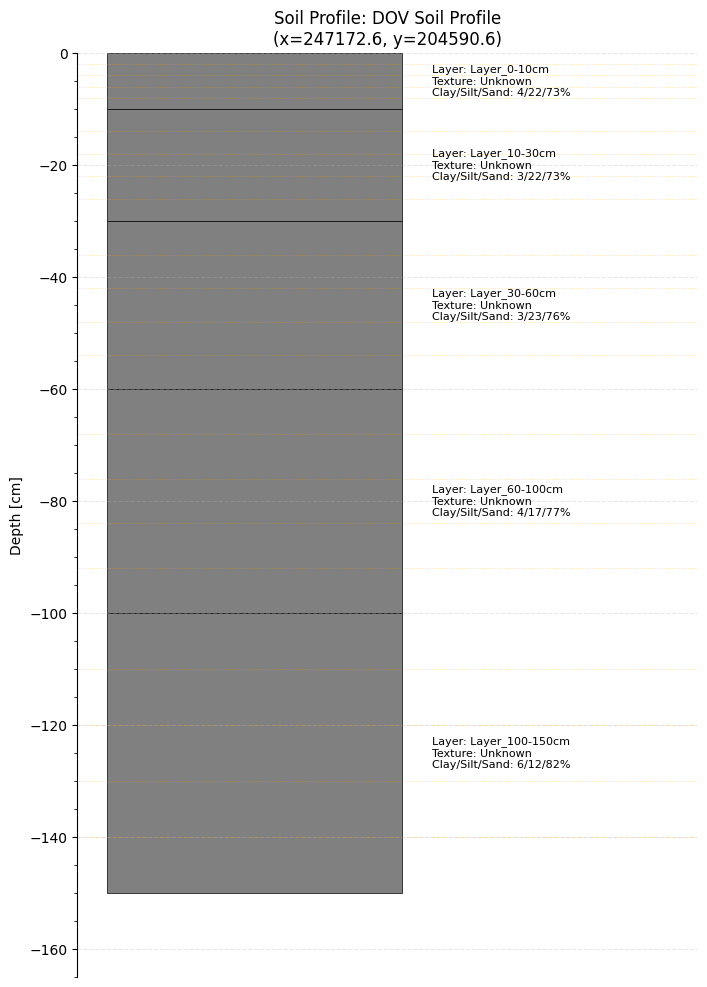

In [ ]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_profile(profile_modelled, ax=ax, show_layer_properties=True, show_sublayers=True)
plt.show()

In [27]:
from simplesoilprofile.models.swap import (
    profile_to_soilhydfunc_table,
    profile_to_sublayer_table,
    profile_to_texture_table,
)

# Convert profile to SWAP tables
modelled_soil_hydraulic = profile_to_soilhydfunc_table(profile_modelled)

# Display the hydraulic parameters table
print("SOILHYDRFUNC table:")
print("==================")
print(modelled_soil_hydraulic.round(4))

modelled_soil_profile = profile_to_sublayer_table(profile_modelled)

# Display the soil profile table
print("\nSOILPROFILE table:")
print("==================")
print(modelled_soil_profile.round(4))


modelled_soil_texture = profile_to_texture_table(profile_modelled)
# Display the soil texture table
print("\nSOILTEXTURE table:")
print("==================")
print(modelled_soil_texture.round(4))

SOILHYDRFUNC table:
   LEXP
0   0.5
1   0.5
2   0.5
3   0.5
4   0.5

SOILPROFILE table:
    ISUBLAY  ISOILLAY  HSUBLAY  NCOMP  HCOMP
0         1         1      2.0     10    0.2
1         2         1      2.0     10    0.2
2         3         1      2.0     10    0.2
3         4         1      2.0     10    0.2
4         5         1      2.0     10    0.2
5         6         2      4.0     10    0.4
6         7         2      4.0     10    0.4
7         8         2      4.0     10    0.4
8         9         2      4.0     10    0.4
9        10         2      4.0     10    0.4
10       11         3      6.0     10    0.6
11       12         3      6.0     10    0.6
12       13         3      6.0     10    0.6
13       14         3      6.0     10    0.6
14       15         3      6.0     10    0.6
15       16         4      8.0     10    0.8
16       17         4      8.0     10    0.8
17       18         4      8.0     10    0.8
18       19         4      8.0     10    0.8
19       20 

## Compute the properties with Rosetta



In [28]:
profile_modelled

SoilProfile(name='DOV Soil Profile', description=None, location=<POINT (247172.56 204590.58)>, elevation=None, layers=[SoilLayer(name='Layer_0-10cm', texture_class=None, discretization=LayerDiscretization(type=<DiscretizationType.EVEN: 'even'>, num_sublayers=5, num_compartments=10, log_density=1.0, compartment_heights=[np.float64(0.2), np.float64(0.2), np.float64(0.20000000000000007), np.float64(0.19999999999999996), np.float64(0.19999999999999996)]), description=None, theta_res=None, theta_sat=None, alpha=None, n=None, k_sat=None, l=0.5, alphaw=None, h_enpr=None, ksatexm=None, bulk_density=None, clay_content=3.611795663833618, silt_content=22.44235610961914, sand_content=72.97166442871094, organic_matter=None, metadata={'sand_content': SoilLayerMetadata(source='DOV WMS, bdbstat:fractie_zand_basisdata_bodemkartering', url=None, source_type='unknown', access_date=None, uncertainty=0.17820630967617035), 'silt_content': SoilLayerMetadata(source='DOV WMS, bdbstat:fractie_leem_basisdata_bod

## Get texture info from texture class

In [29]:
from simplesoilprofile.models.profile import get_profile_from_dov

profile = get_profile_from_dov(location=Point(247172.56, 204590.58), fetch_elevation=True)
